#Задача: Определить категории новостей

Это решение расположено в репозитории https://github.com/crazyelf1971/odb21/

##Описание задачи

https://open-data-battle.geecko.com/issues/news

Мы решили торговать на бирже, причем так, чтобы решение о покупке акций принимала нейросеть на основе последних новостей о той или иной компании. Для этого нужно научиться классифицировать все новости. Дана база новостей из разных источников news.csv. Необходимо написать классифицирующую модель новостей по источникам.

Напиши любую модель для предсказания источника новостей и предскажите источники для данных из файла news.csv, для которых отсутствует значение Source.

Пороговые значения для данной задачи классификации считать равными 0.33, 0.66.

Ответ необходимо прикрепить в файле формата CSV. Файл должен содержать только прогнозные значения Source в одном столбце без заголовка.

Для успешного прохождения достаточно иметь 70% точность решения

Обратите внимание, что в таблице не должно быть пустых значений. Проверяйте файл решения через Блокнот, Notepad++ или их аналоги на отсутствие пустой строки в конце решения!

##Скачивание данных

Если ссылка на соревнование перестанет быть актуальной, можно будет взять файлы из моего репозитория с решениями https://github.com/crazyelf1971/odb21  
При запуске не из Google Colab можно использовать для скачки библиотеку wget и вызовы os.system, либо просто взять готовый csv файл из репозитория и пропустить этот шаг.

In [1]:
import gdown

file_name = gdown.download('https://open-data-battle.geecko.com/dataset/news.zip', None, False)
!unzip {file_name}
!ls -la *.csv

Downloading...
From: https://open-data-battle.geecko.com/dataset/news.zip
To: /content/news.zip
20.8MB [00:12, 1.70MB/s]


Archive:  news.zip
  inflating: news (1).csv            
  inflating: __MACOSX/._news (1).csv  
-rw-r--r-- 1 root root 71866109 Aug 30 10:24 'news (1).csv'


##Загрузка данных

In [2]:
import pandas as pd

# загрузка csv
df = pd.read_csv('news (1).csv', index_col=0)
df.info(memory_usage='deep')

# разделение данных на train и test
test_flag = df.source.isna()
x_train = df.loc[~test_flag, 'news'].values
y_train = df.loc[~test_flag, 'source'].values
x_test = df.loc[test_flag, 'news'].values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19462 entries, 0 to 19461
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   news    19462 non-null  object 
 1   source  18360 non-null  float64
dtypes: float64(1), object(1)
memory usage: 79.3 MB


###Баланс классов

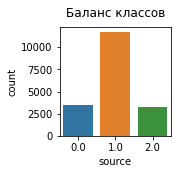

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(2, 2))
sns.countplot(x='source', data=df);
plt.title('Баланс классов', pad=10);

Данные по классам сбалансированы примерно в пропорциях 1:3:1.  
Сильно не сбалансированными считаются классы в пропорции 10:1 и более.

###Пример данных

In [4]:
df.iloc[-1, 0]

' Компания INOI смогла реализовать 1,5 млн смартфонов под управлением Android за прошлый год. Самой популярной моделью бренда стал телефон INOI 2 и его модификация INOI 2 Lite, всего было продано 400 000 единиц. В ближайшее время компания планирует выпустить обновления для своих хитов: INOI 2 2019 и INOI 2 Lite 2019. INOI 2 — это 4G-смартфон с пятидюймовым экраном, прикрытым 2,5D стеклом. Работает под управлением Android 7 Nougat, а за производительность отвечает 4-ядерный процессор MediaTek 6737. В младшей версии смартфона установлен более слабый чип — MTK6580. INOI 2 INOI 3 INOI 5X Lite INOI 2 Lite Сейчас компания имеет свои представительства в России, Казахстане, Киргизии, Грузии, Азербайджане, Белоруссии, а в её ассортименте представлены устройства стоимостью от 2290 до 6999 рублей. '

##Обработка данных

Подготовка текстовых данных для обучения модели обычно выглядит следующим образом:
*   убрать пунктуацию
*   привести слова к одинаковому регистру
*   убрать стоп-слова
*   исправить опечатки
*   лемматизация либо стемминг
*   векторизация слов: бинарный признак, счётчик, либо TF/IDF
*   понижение размерности данных

В данном случае для успешного прохождения задачи оказалось достаточным сделать минимальную обработку:
*   векторизация слов
*   понижение размерности данных  

Для векторизации использован `HashingVectorizer`:  
- поскольку он `stateless` он может давать качество чуть хуже, чем `statefull` векторизаторы, но зато он хорошо экономит память, поскольку не хранит состояние и выдаёт *разреженную матрицу* на выходе
- в данном случае оказалось полезным учитывать не счётчик слов, а просто признак присутствия слова
- учёт сочетаний из двух слов также оказался полезным 

Для понижения размерности использован `TruncatedSVD`:  
- он умеет работать с *разреженными матрицами*, что сильно экономит память
- для этих данных оказалось достаточно размерности 5 на выходе, хотя обычно делают больше


In [5]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

In [6]:
# получаем матрицу текста
vectorizer = HashingVectorizer(binary=True, ngram_range=(1,2))
train_matrix = vectorizer.fit_transform(x_train)
print(train_matrix.shape)
test_matrix = vectorizer.fit_transform(x_test)
print(test_matrix.shape)

(18360, 1048576)
(1102, 1048576)


In [7]:
# понижаем размерность данных
svd = TruncatedSVD(5)
svd.fit(train_matrix)
train_svd = svd.transform(train_matrix)
test_svd = svd.transform(test_matrix)

###Визуализация разделения данных в пространстве пониженной размерности

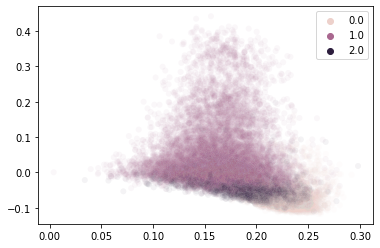

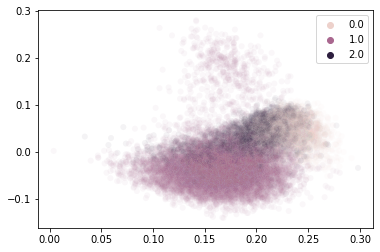

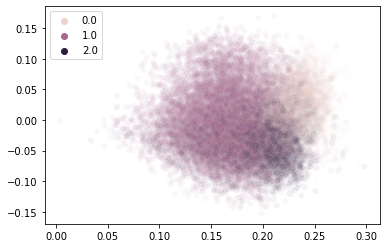

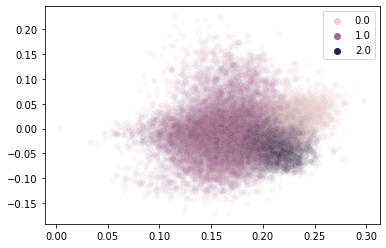

In [8]:
for i in range(train_svd.shape[1]-1):
    plt.figure()
    sns.scatterplot(x=train_svd[:,0], y=train_svd[:,i+1], hue=y_train, alpha=0.05);

Видно, что классы 0 и 1 довольно хорошо разделимы между собой, а вот класс 2 "подмешан" в классы 0 и 1 и с его отделением могут быть проблемы, что мы в дальнейшем и увидим.

##Проверка качества различных моделей на наших данных

In [9]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import numpy as np
import time
from xgboost import XGBClassifier, XGBRFClassifier

In [10]:
skf = StratifiedKFold()
classifiers = [LogisticRegression, SVC, AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier,
               LGBMClassifier, XGBClassifier, XGBRFClassifier, KNeighborsClassifier]
# сортировка для красоты показа
classifiers = sorted(classifiers, key=lambda x: (len(x.__name__), x.__name__))
models = []
quality = []
speed = []
# учим на фолдах, предсказываем, проверяем качество на отложенном фолде
for model_type in classifiers:
    model_name = model_type.__name__
    print(model_name, end=': ')
    models.append(model_name)
    scores = []
    t1 = time.time()
    model = model_type()
    for index_train, index_test in skf.split(train_svd, y_train):
        X = train_svd[index_train]
        y = y_train[index_train]
        X_valid = train_svd[index_test]
        y_valid = y_train[index_test]
        model.fit(X, y)
        preds = model.predict(X_valid)
        score = balanced_accuracy_score(y_valid, preds, adjusted=True)
        scores.append(score)
        print('.', end='')
    t2 = time.time()
    tdelta = t2-t1
    speed.append(tdelta)
    q = np.mean(scores)
    quality.append(q)
    print(f' {q:.2f} (± {np.std(scores):.2f}) [{tdelta:.1f}с]')
df_class = pd.DataFrame({'model': models, 'score': quality, 'time': speed})

SVC: ..... 0.78 (± 0.00) [14.3с]
XGBClassifier: ..... 0.78 (± 0.01) [11.2с]
LGBMClassifier: ..... 0.78 (± 0.01) [3.6с]
XGBRFClassifier: ..... 0.73 (± 0.01) [8.3с]
AdaBoostClassifier: ..... 0.73 (± 0.04) [4.6с]
LogisticRegression: ..... 0.75 (± 0.01) [1.9с]
ExtraTreesClassifier: ..... 0.77 (± 0.01) [4.9с]
KNeighborsClassifier: ..... 0.77 (± 0.01) [0.8с]
RandomForestClassifier: ..... 0.78 (± 0.00) [15.1с]


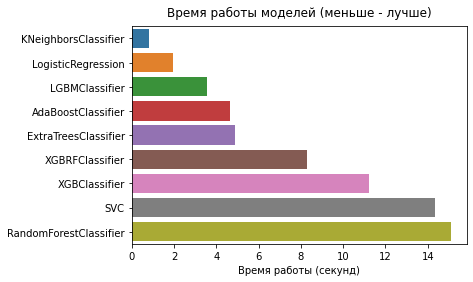

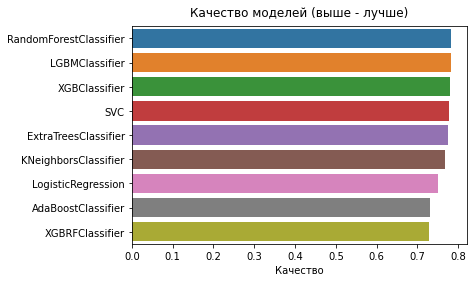

In [11]:
plt.figure()
sns.barplot(x='time', y='model', data=df_class.sort_values('time'))
plt.xlabel('Время работы (секунд)')
plt.ylabel('')
plt.title('Время работы моделей (меньше - лучше)', pad=10);

plt.figure()
sns.barplot(x='score', y='model', data=df_class.sort_values('score', ascending=False))
plt.xlabel('Качество')
plt.ylabel('')
plt.title('Качество моделей (выше - лучше)', pad=10);

Наглядно видно, что (по крайней мере при настройках моделей по умолчанию):  
- `KNeighborsClassifier` - самая быстрая модель из протестированных, при этом она лишь немного уступает лучшим по  качеству моделям  
- `LGBMClassifier` находится в группе лучших по качеству моделей, при этом работает довольно быстро; и хотя она уступает по скорости самой быстрой модели в несколько раз, но остальные модели такого же качества работают ещё дольше
- `ExtraTreesClassifier` среди "деревянных" моделей работает наиболее быстро и в то же время качественно на текстовых данных
- `SVC`, `XGBClassifier` и `RandomForestClassifier` хотя и дают очень хорошее качество, но работают слишком долго по сравнению с другими моделями; в какой-то степени это можно исправить настройками в случае `XGBClassifier`, а вот `SVC` и `RF` сейчас уже почти не применяют из-за недостаточной скорости работы

##Предсказание

###Проверка качества обучения модели на тренировочных данных

In [12]:
model = KNeighborsClassifier()
model.fit(train_svd, y_train)
test = model.predict(train_svd)
print('balanced score', balanced_accuracy_score(y_train, test, adjusted=True))

balanced score 0.8255679873580746


Количество неправильно предсказанных источников в трейне: 1396 из 18360


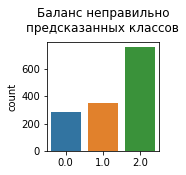

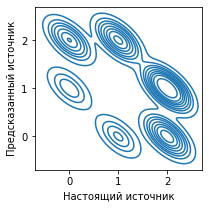

In [13]:
print(f'Количество неправильно предсказанных источников в трейне: {x_train[y_train != test].shape[0]} из {x_train.shape[0]}')

plt.figure(figsize=(2, 2))
sns.countplot(x=y_train[y_train != test]);
plt.title('Баланс неправильно\nпредсказанных классов', pad=10);

plt.figure(figsize=(3, 3))
sns.kdeplot(x=y_train[y_train != test], y=test[y_train != test])
plt.xlabel('Настоящий источник')
plt.ylabel('Предсказанный источник');
plt.yticks(range(3));

В основном проблемы с правильным предсказанием источника 2 - вместо него предсказываются 0 и 1.  
Хотя есть и обратный эффект - источники 0 и 1 часто предсказываются как источник 2.  
При этом источники 0 и 1 довольно редко путаются между собой.

###Предсказание на тестовой части данных

In [14]:
preds = model.predict(test_svd)
df_preds = pd.DataFrame({'preds': preds})
df_preds.preds = df_preds.preds.astype(int)
df_preds.to_csv('news_preds.csv', header=False, index=False)

###Баланс классов в предсказании

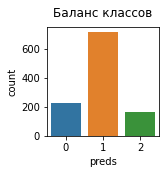

In [15]:
df_preds.value_counts(normalize=True)
plt.figure(figsize=(2, 2))
sns.countplot(x='preds', data=df_preds);
plt.title('Баланс классов', pad=10);

Баланс в целом похож на баланс в тренировочной части, но видно, что источника 2 предсказано меньше, чем в трейне.

In [16]:
!head news_preds.csv

0
1
1
1
1
2
1
2
0
1
